In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np


In [2]:
data = pd.read_csv('../data/processed/clean_raw_text_merged.csv')
print(data)


                                                 request  label
0      modo entrar login barkwill8 pwd desmoralizaci�...      0
1      entrar modo entrar login berenice pwda enfeuda...      1
2      boudaoudi-griffeth@muchacha.com.dz dni 1307408...      1
3      "modo registro login guilbaul password 5oment_...      0
4      registro login romani password vol'tura nombre...      1
...                                                  ...    ...
42607             modo insertar precio 4760 b1 confirmar      0
42608                                               id 1      0
42609  "modo registro login baominh password 2a!l01t6...      0
42610                                  b2 vaciar carrito      0
42611  modo entrar login jia pwd 2e64n8m5 remember on...      0

[42612 rows x 2 columns]


In [3]:
labels = data['label']


2.Define a text preprocessing pipeline, i.e., stopword removal, lower casing, punctuation removal etc
1.Define your own train-val-test split. Ratio : (train: 18: test : 5 , val : 2)

In [4]:
from nltk.corpus import stopwords
import nltk
import re
nltk.download('stopwords')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))


def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = text.replace('x', '')
    text = text.replace('\d+', '')

#    text = re.sub(r'\W+', '', text)
    # remove stopwors from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text


requests = data['request'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\debon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    requests, labels, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=1)


In [6]:
print(X_test.shape)
print(X_train.shape)
print(X_val.shape)


(8523,)
(30680,)
(3409,)


Developing ML methods:
1. Model a Naive Bayes classifier.
a. Count vectorizer features.
b. TF-IDF features.


In [7]:
vectorizer = CountVectorizer()
X_train_count = vectorizer.fit_transform(X_train)
clf = MultinomialNB()
clf.fit(X_train_count, y_train)

X_test_count = vectorizer.transform(X_test)
y_pred = clf.predict(X_test_count)
accuracy = accuracy_score(y_test, y_pred)


In [8]:
print(accuracy*100)


98.48644843365012


In [9]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)

clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

X_test_tfidf = vectorizer.transform(X_test)
y_pred = clf.predict(X_test_tfidf)
accuracy_tfidf = accuracy_score(y_test, y_pred)


In [10]:
print(accuracy_tfidf*100)


94.22738472368884


3. ii ) Model a decision tree with TF-IDF features

In [11]:
clf = DecisionTreeClassifier()
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
accuracy_dec = accuracy_score(y_test, y_pred)


In [12]:
print(accuracy_dec*100)


92.4439751261293


4. Developing Deep neural networks:

    a. RNN model.
    
      1. 64 hidden-vector dimension.


In [13]:
# helps in model building
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import InputLayer
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.callbacks import EarlyStopping


In [14]:
# helps in text preprocessing
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

t = Tokenizer()
t.fit_on_texts(X_train)


In [15]:
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)
encoded_val = t.texts_to_sequences(X_val)
print(encoded_train[0:2])


[[33, 29, 31], [33, 29, 31]]


In [16]:
max_length = 128
word_embed_dim = 100
vocab_size = len(t.word_index) + 1
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
padded_val = pad_sequences(encoded_val, maxlen=max_length, padding='post')
print(padded_train)


[[33 29 31 ...  0  0  0]
 [33 29 31 ...  0  0  0]
 [19 27  3 ...  0  0  0]
 ...
 [33 29 31 ...  0  0  0]
 [ 2 16  4 ...  0  0  0]
 [ 2 25 17 ...  0  0  0]]


In [17]:

# define the model
RNNModel64 = Sequential(name="SimpleRNNModel64")
RNNModel64.add(Embedding(vocab_size, word_embed_dim, input_length=max_length))
RNNModel64.add(SimpleRNN(64, dropout=0.2, return_sequences=False))
RNNModel64.add(Dense(64, activation='relu'))
RNNModel64.add(keras.layers.Dropout(0.2))
RNNModel64.add(Dense(1, activation='relu'))


opt = keras.optimizers.Adam(1e-5)

# compile the model
RNNModel64.compile(optimizer=opt, loss='binary_crossentropy',
                   metrics=['accuracy'])

# summarize the model
print(RNNModel64.summary())


Model: "SimpleRNNModel64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 100)          4910500   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,925,285
Trainable params: 4,925,285
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
def plot_training_graph(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


Epoch 1/100
959/959 [==============================] - 107s 110ms/step - loss: 0.6244 - accuracy: 0.7501 - val_loss: 0.4548 - val_accuracy: 0.7504
Epoch 2/100
959/959 [==============================] - 116s 121ms/step - loss: 0.4957 - accuracy: 0.8078 - val_loss: 0.3747 - val_accuracy: 0.8730
Epoch 3/100
959/959 [==============================] - 115s 120ms/step - loss: 0.3983 - accuracy: 0.8954 - val_loss: 0.3082 - val_accuracy: 0.9205
Epoch 4/100
959/959 [==============================] - 104s 108ms/step - loss: 0.3327 - accuracy: 0.9283 - val_loss: 0.2523 - val_accuracy: 0.9405
Epoch 5/100
959/959 [==============================] - 88s 92ms/step - loss: 0.2243 - accuracy: 0.9588 - val_loss: 0.3826 - val_accuracy: 0.9440
Epoch 6/100
959/959 [==============================] - 92s 96ms/step - loss: 0.1925 - accuracy: 0.9692 - val_loss: 0.5218 - val_accuracy: 0.9463
Epoch 7/100
959/959 [==============================] - 111s 115ms/step - loss: 0.1596 - accuracy: 0.9760 - val_loss: 0.531

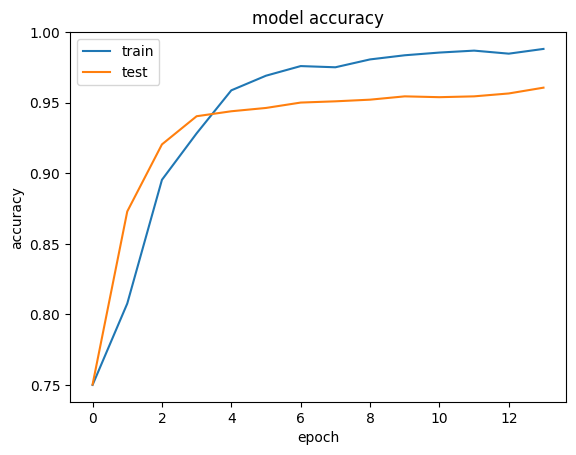

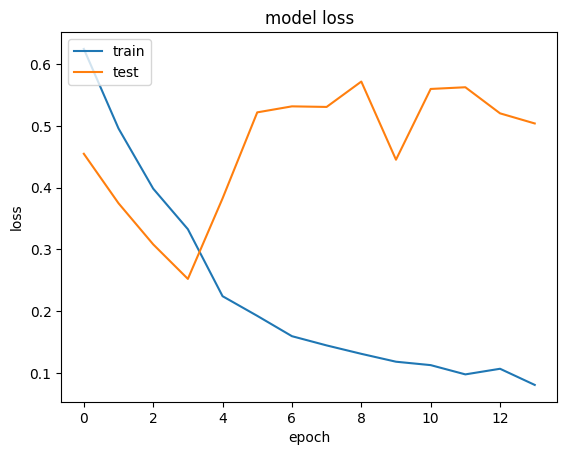

In [19]:
early_stop = EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
history = RNNModel64.fit(x=padded_train,
                         y=y_train,
                         epochs=100,
                         validation_data=(padded_val, y_val), verbose=1,
                         callbacks=[early_stop]
                         )
plot_training_graph(history)


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns


def c_report(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    acc_sc = accuracy_score(y_true, y_pred)
    print("Accuracy : " + str(acc_sc))
    return acc_sc


def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,
                cmap="Blues", cbar=False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [21]:
preds_rnn_64 = (RNNModel64.predict(padded_test) > 0.5).astype("int32")


267/267 [==============================] - 3s 9ms/step


In [22]:
c_report(y_test, preds_rnn_64)


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      6381
           1       0.88      0.97      0.92      2142

    accuracy                           0.96      8523
   macro avg       0.93      0.96      0.95      8523
weighted avg       0.96      0.96      0.96      8523

Accuracy : 0.9589346474246158


0.9589346474246158

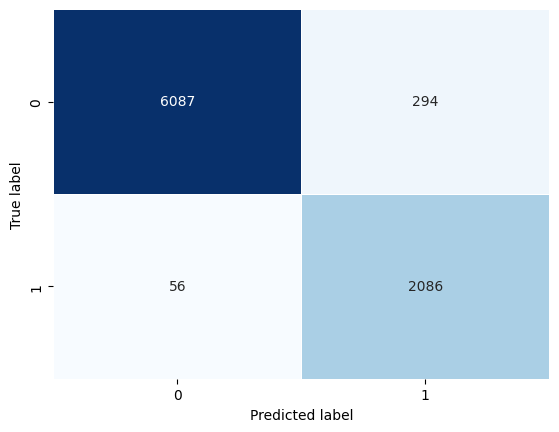

In [23]:
plot_confusion_matrix(y_test, preds_rnn_64)


4. Developing Deep neural networks:

    a. RNN model.
    
      2. 256 hidden-vector dimension.


In [24]:
# define the model
RNNModel256 = Sequential(name="SimpleRNNModel256")
RNNModel256.add(Embedding(vocab_size, word_embed_dim, input_length=max_length))
RNNModel256.add(SimpleRNN(256, dropout=0.2, return_sequences=False))
RNNModel256.add(Dense(64, activation='relu'))
RNNModel256.add(keras.layers.Dropout(0.2))
RNNModel256.add(Dense(1, activation='relu'))


opt = keras.optimizers.Adam(learning_rate=1e-5)

# compile the model
RNNModel256.compile(
    optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(RNNModel256.summary())


Model: "SimpleRNNModel256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 100)          4910500   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 256)               91392     
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,018,405
Trainable params: 5,018,405
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/100
959/959 [==============================] - 125s 129ms/step - loss: 0.3268 - accuracy: 0.8986 - val_loss: 0.3349 - val_accuracy: 0.9525
Epoch 2/100
959/959 [==============================] - 131s 137ms/step - loss: 0.2073 - accuracy: 0.9572 - val_loss: 0.3498 - val_accuracy: 0.9495
Epoch 3/100
959/959 [==============================] - 130s 135ms/step - loss: 0.8346 - accuracy: 0.7088 - val_loss: 0.4239 - val_accuracy: 0.8131
Epoch 4/100
959/959 [==============================] - 134s 140ms/step - loss: 0.4095 - accuracy: 0.8285 - val_loss: 0.2983 - val_accuracy: 0.9405
Epoch 5/100
959/959 [==============================] - 184s 192ms/step - loss: 0.2518 - accuracy: 0.9414 - val_loss: 0.1460 - val_accuracy: 0.9745
Epoch 6/100
959/959 [==============================] - 200s 208ms/step - loss: 0.4363 - accuracy: 0.8463 - val_loss: 0.4293 - val_accuracy: 0.8856
Epoch 7/100
959/959 [==============================] - 230s 239ms/step - loss: 0.3771 - accuracy: 0.8666 - val_loss: 0

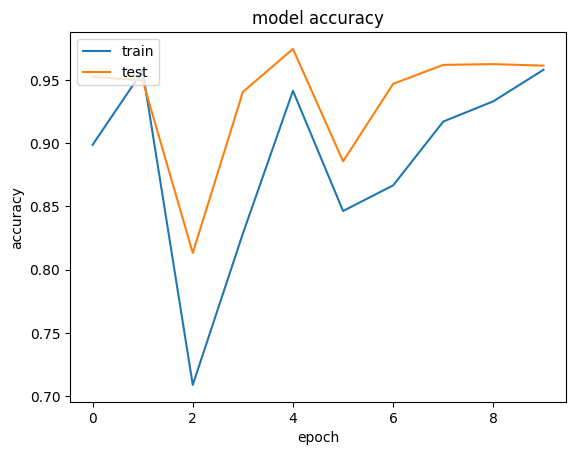

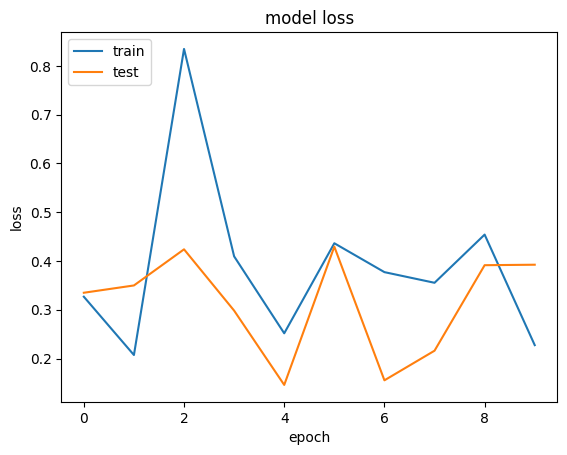

In [25]:
early_stop = EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=5)

# fit the model
history = RNNModel256.fit(x=padded_train,
                          y=y_train,
                          epochs=100,
                          validation_data=(padded_val, y_val), verbose=1,
                          callbacks=[early_stop]
                          )
plot_training_graph(history)


In [26]:
preds_rnn_256 = (RNNModel256.predict(padded_test) > 0.5).astype("int32")


267/267 [==============================] - 10s 35ms/step


In [27]:
c_report(y_test, preds_rnn_256)


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6381
           1       0.89      0.96      0.92      2142

    accuracy                           0.96      8523
   macro avg       0.94      0.96      0.95      8523
weighted avg       0.96      0.96      0.96      8523

Accuracy : 0.9591693065821894


0.9591693065821894

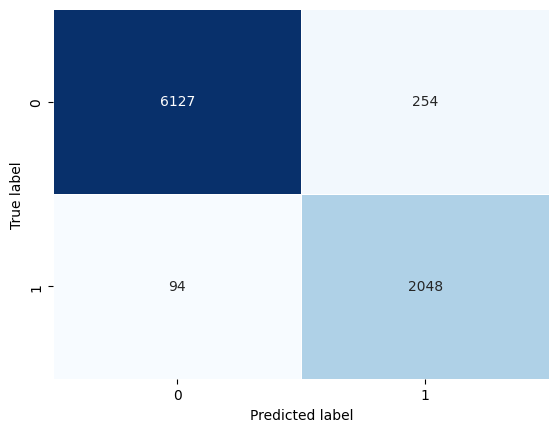

In [28]:
plot_confusion_matrix(y_test, preds_rnn_256)


4. Developing Deep neural networks:

    b. 1-layer LSTM model


In [29]:
# define the model
SingleLSTMLayer64 = Sequential(name="SingleLSTMLayer64")
SingleLSTMLayer64.add(
    Embedding(vocab_size, word_embed_dim, input_length=max_length))
SingleLSTMLayer64.add(LSTM(64, dropout=0.2, return_sequences=False))
SingleLSTMLayer64.add(Dense(64, activation='relu'))
SingleLSTMLayer64.add(keras.layers.Dropout(0.1))
SingleLSTMLayer64.add(Dense(1, activation='relu'))


opt = keras.optimizers.Adam(learning_rate=1e-5)

# compile the model
SingleLSTMLayer64.compile(
    optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(SingleLSTMLayer64.summary())


Model: "SingleLSTMLayer64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 128, 100)          4910500   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,956,965
Trainable params: 4,956,965
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/100
959/959 [==============================] - 185s 187ms/step - loss: 0.6017 - accuracy: 0.7517 - val_loss: 0.5620 - val_accuracy: 0.7504
Epoch 2/100
959/959 [==============================] - 187s 195ms/step - loss: 0.5627 - accuracy: 0.7517 - val_loss: 0.5620 - val_accuracy: 0.7504
Epoch 3/100
959/959 [==============================] - 215s 224ms/step - loss: 0.5623 - accuracy: 0.7517 - val_loss: 0.5622 - val_accuracy: 0.7504
Epoch 4/100
959/959 [==============================] - 169s 176ms/step - loss: 0.5622 - accuracy: 0.7517 - val_loss: 0.5621 - val_accuracy: 0.7504
Epoch 5/100
959/959 [==============================] - 176s 184ms/step - loss: 0.5625 - accuracy: 0.7517 - val_loss: 0.5619 - val_accuracy: 0.7504
Epoch 6/100
959/959 [==============================] - 170s 177ms/step - loss: 0.5625 - accuracy: 0.7517 - val_loss: 0.5619 - val_accuracy: 0.7504
Epoch 7/100
959/959 [==============================] - 179s 186ms/step - loss: 0.5615 - accuracy: 0.7517 - val_loss: 0

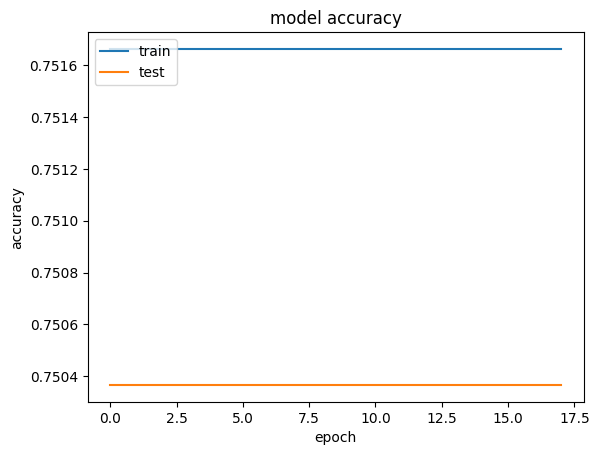

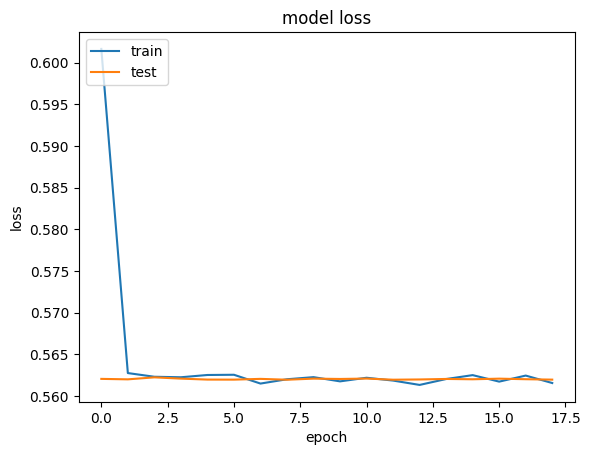

In [30]:
early_stop = EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
history = SingleLSTMLayer64.fit(x=padded_train,
                                y=y_train,
                                epochs=100,
                                validation_data=(padded_val, y_val), verbose=1,
                                callbacks=[early_stop]
                                )
plot_training_graph(history)


In [31]:
preds_1_lstm_64 = (SingleLSTMLayer64.predict(
    padded_test) > 0.5).astype("int32")


267/267 [==============================] - 11s 37ms/step


In [32]:
c_report(y_test, preds_1_lstm_64)


Classification Report
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      6381
           1       0.00      0.00      0.00      2142

    accuracy                           0.75      8523
   macro avg       0.37      0.50      0.43      8523
weighted avg       0.56      0.75      0.64      8523

Accuracy : 0.7486800422386484


c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

0.7486800422386484

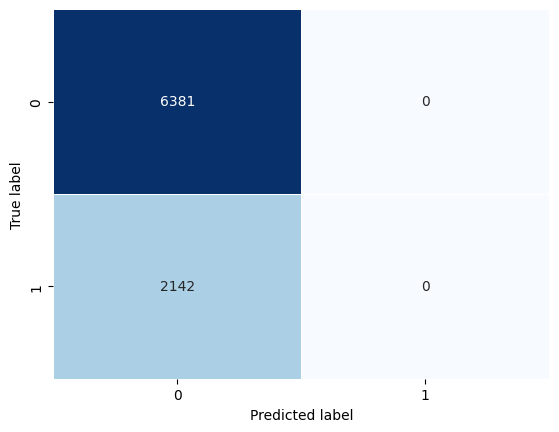

In [33]:
plot_confusion_matrix(y_test, preds_1_lstm_64)


4. Developing Deep neural networks:

    c. 2-layer LSTM model


In [34]:
# define the model
DoubleLSTMLayer64 = Sequential(name="DoubleLSTMLayer64")
DoubleLSTMLayer64.add(
    Embedding(vocab_size, word_embed_dim, input_length=max_length))
DoubleLSTMLayer64.add(LSTM(64, dropout=0.2, return_sequences=True))
DoubleLSTMLayer64.add(LSTM(32, dropout=0.2, return_sequences=False))
DoubleLSTMLayer64.add(Dense(32, activation='relu'))
DoubleLSTMLayer64.add(keras.layers.Dropout(0.1))
DoubleLSTMLayer64.add(Dense(1, activation='relu'))


opt = keras.optimizers.Adam(learning_rate=1e-5)

# compile the model
DoubleLSTMLayer64.compile(
    optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(DoubleLSTMLayer64.summary())


Model: "DoubleLSTMLayer64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 128, 100)          4910500   
                                                                 
 lstm_1 (LSTM)               (None, 128, 64)           42240     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,966,245
Trainable params: 4,966,2

In [35]:
early_stop = EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
history = DoubleLSTMLayer64.fit(x=padded_train,
                                y=y_train,
                                epochs=100,
                                validation_data=(padded_val, y_val), verbose=1,
                                callbacks=[early_stop]
                                )
plot_training_graph(history)


Epoch 1/100
959/959 [==============================] - 254s 255ms/step - loss: 1.3962 - accuracy: 0.7517 - val_loss: 0.7617 - val_accuracy: 0.7504
Epoch 2/100
959/959 [==============================] - 207s 216ms/step - loss: 0.7219 - accuracy: 0.7517 - val_loss: 0.6580 - val_accuracy: 0.7504
Epoch 3/100
959/959 [==============================] - 200s 209ms/step - loss: 0.6317 - accuracy: 0.7517 - val_loss: 0.5922 - val_accuracy: 0.7504
Epoch 4/100
959/959 [==============================] - 257s 268ms/step - loss: 0.5797 - accuracy: 0.7517 - val_loss: 0.5640 - val_accuracy: 0.7504
Epoch 5/100
959/959 [==============================] - 267s 278ms/step - loss: 0.5664 - accuracy: 0.7517 - val_loss: 0.5619 - val_accuracy: 0.7504
Epoch 6/100
959/959 [==============================] - 11056s 12s/step - loss: 0.5658 - accuracy: 0.7517 - val_loss: 0.5620 - val_accuracy: 0.7504
Epoch 7/100
959/959 [==============================] - 195s 204ms/step - loss: 0.5666 - accuracy: 0.7517 - val_loss: 0

KeyboardInterrupt: 

In [ ]:
preds_2_lstm_64 = (DoubleLSTMLayer64.predict(
    padded_test) > 0.5).astype("int32")


In [ ]:
c_report(y_test, preds_2_lstm_64)


In [ ]:
plot_confusion_matrix(y_test, preds_2_lstm_64)


4. Developing Deep neural networks:

    d. 1-layer Bi-LSTM model


In [ ]:
# define the model
SingleBiLSTMModel = Sequential(name="SingleBiLSTMModel")
SingleBiLSTMModel.add(
    Embedding(vocab_size, word_embed_dim, input_length=max_length))
SingleBiLSTMModel.add(Bidirectional(
    LSTM(64, dropout=0.2, return_sequences=False)))
SingleBiLSTMModel.add(Dense(32, activation='relu'))
SingleBiLSTMModel.add(keras.layers.Dropout(0.1))
SingleBiLSTMModel.add(Dense(1, activation='relu'))


opt = keras.optimizers.Adam(learning_rate=1e-5)

# compile the model
SingleBiLSTMModel.compile(
    optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(SingleBiLSTMModel.summary())


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
history = SingleBiLSTMModel.fit(x=padded_train,
                                y=y_train,
                                epochs=100,
                                validation_data=(padded_val, y_val), verbose=1,
                                callbacks=[early_stop]
                                )
plot_training_graph(history)


In [ ]:
preds_bilstm_64 = (SingleBiLSTMModel.predict(
    padded_test) > 0.5).astype("int32")


313/313 [==============================] - 7s 19ms/step


In [ ]:
c_report(y_test, preds_bilstm_64)


In [ ]:
plot_confusion_matrix(y_test, preds_bilstm_64)


4. Developing Deep neural networks:

    e. Use Google word2vec embeddings as input embedding to model in 4.d. [Compare the performance 4.e vs 4.d]


In [ ]:
from gensim.models import Word2Vec

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                          vector_size=word_embed_dim,
                          workers=8,
                          min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))


In [ ]:
vocab_size = len(t.word_index) + 1
embedding_matrix = np.zeros((vocab_size, word_embed_dim))

for word, token in t.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)


In [ ]:
#max_length = 64

# define the model
BiLSTMLayerWithWord2Vec = Sequential(name="BiLSTMLayerWithWord2Vec")
BiLSTMLayerWithWord2Vec.add(Embedding(vocab_size, word_embed_dim, input_length=max_length,
                                      weights=[embedding_matrix], trainable=False))
#BiLSTMLayerWithWord2Vec.add(Bidirectional(LSTM(128, dropout=0.3, return_sequences=True)))
BiLSTMLayerWithWord2Vec.add(Bidirectional(
    LSTM(64, dropout=0.2, return_sequences=False)))
BiLSTMLayerWithWord2Vec.add(Dense(32, activation='relu'))
BiLSTMLayerWithWord2Vec.add(Dropout(0.1))
BiLSTMLayerWithWord2Vec.add(Dense(1, activation='relu'))


opt = keras.optimizers.Adam(learning_rate=1e-5)

# compile the model
BiLSTMLayerWithWord2Vec.compile(
    optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(BiLSTMLayerWithWord2Vec.summary())


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
history = BiLSTMLayerWithWord2Vec.fit(x=padded_train,
                                      y=y_train,
                                      epochs=100,
                                      validation_data=(
                                          padded_val, y_val), verbose=1,
                                      callbacks=[early_stop]
                                      )
plot_training_graph(history)


In [ ]:
preds_bilstm_64_w2v = (BiLSTMLayerWithWord2Vec.predict(
    padded_test) > 0.5).astype("int32")


313/313 [==============================] - 10s 32ms/step


In [ ]:
c_report(y_test, preds_bilstm_64_w2v)
plot_confusion_matrix(y_test, preds_bilstm_64_w2v)


#### 4.f. Use Glove embeddings as input embedding to model in 4.d. [Compare the performance performance 4.f vs 4.d]

In [ ]:
embeddings_index = dict()
#f = open('glove.6B.50d.txt')
embeddings_index = {}
with open('./downloads/glove.6B/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Loaded %s word vectors.' % len(embeddings_index))


Loaded 400000 word vectors.


In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, word_embed_dim))
for word, index in t.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector


In [ ]:
#max_length = 64

# define the model
BiLSTMLayerWithGloVe = Sequential(name="BiLSTMLayerWithGloVe")
BiLSTMLayerWithGloVe.add(Embedding(vocab_size, word_embed_dim, input_length=max_length,
                                   weights=[embedding_matrix], trainable=False))
#BiLSTMLayerWithWord2Vec.add(Bidirectional(LSTM(128, dropout=0.3, return_sequences=True)))
BiLSTMLayerWithGloVe.add(Bidirectional(
    LSTM(64, dropout=0.2, return_sequences=False)))
BiLSTMLayerWithGloVe.add(Dense(32, activation='relu'))
BiLSTMLayerWithGloVe.add(Dropout(0.1))
BiLSTMLayerWithGloVe.add(Dense(1, activation='relu'))


opt = keras.optimizers.Adam(learning_rate=1e-5)

# compile the model
BiLSTMLayerWithGloVe.compile(
    optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(BiLSTMLayerWithGloVe.summary())


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
history = BiLSTMLayerWithGloVe.fit(x=padded_train,
                                   y=y_train,
                                   epochs=100,
                                   validation_data=(
                                       padded_val, y_val), verbose=1,
                                   callbacks=[early_stop]
                                   )
plot_training_graph(history)


In [ ]:
preds_bilstm_64_glove = (BiLSTMLayerWithGloVe.predict(
    padded_test) > 0.5).astype("int32")


313/313 [==============================] - 8s 23ms/step


In [ ]:
c_report(y_test, preds_bilstm_64_glove)
plot_confusion_matrix(y_test, preds_bilstm_64_glove)


In [ ]:

# Plotly
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import string
import nltk
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
# Others


In [ ]:
word_list = []
for word, i in t.word_index.items():
    word_list.append(word)


In [ ]:
def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x=data[start:stop:step, 0],
        y=data[start:stop:step, 1],
        mode='markers',
        text=word_list[start:stop:step]
    )
    layout = dict(title='glove.50 vs IMDB',
                  yaxis=dict(title='glove.50'),
                  xaxis=dict(title='IMDB'),
                  hovermode='closest')
    fig = dict(data=[trace], layout=layout)
    py.iplot(fig)


In [ ]:
glove_emds = BiLSTMLayerWithGloVe.layers[0].get_weights()[0]


In [ ]:
glove_tsne_embds = TSNE(n_components=2, learning_rate='auto',
                        init='pca').fit_transform(glove_emds)


In [ ]:
number_of_words = 2000
plot_words(glove_tsne_embds, 0, number_of_words, 1)
